# Group Project Report: Diagnostic Model for Chest Pain

### Section 009 Group 3 (Adeesh Devanand, Eddie Han, Connor Law, Burak Ozkan)

## 1) Introduction

Heart disease is an umbrella term used to define a range of health conditions that **negatively affect** the health of **the heart** or more generally the cardiovascular system, such as **coronary artery disease** which is the narrowing of blood vessels by cholesterol deposits that, especially when it occurs in coronary arteries, **can lead to a heart attack** and sudden death (CDC, 2021). **Chest pain** is a symptom of a heart attack and indicates to the patient that they should seek immediate primary care (NHS, 2023). 

For our project, we would like to explore the following question: **can variables measured during the diagnosis of a heart disease be used to predict where or not the individual will experience chest pain that could potentially be a heart attack?** We are using the "**Heart Disease Dataset**" by David Lapp, obtained from the Kaggle website (https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset/data) which contains data regarding patients' health predictors, specifically acquired from the **Cleveland data set**, for our model.

We will be using ```cp - chest pain type (4 values)``` as the **response variable**. The classifications are zero to three and their descriptions are as follows:
```
0. non-cardiac causes OR no chest pain.
1. mild or minor chest discomfort, usually of non-cardiac origin.
2. moderate chest pain, which may have cardiac or non-cardiac origins.
3. severe or intense chest pain requiring immediate medical attention.
```
For preventative medicine purposes, it is important to know whether an individual's health status predisposes them to experiencing chest pain, of any form, rather than knowing the type of chest pain they will experience.

Therefore, we have decided to group the observations to yield **two classes** for the response variable rather than four classes. The '0' class will indicate that the individual is likely to not experience chest pain, hence being **asymptomatic**. We will group observations labeled 1,2,3 into one class that will be named **symptomatic**.

We have eliminated all other categorical variables and have focused on predictors that are either **measurable** or **well understood** by the general public. The **four predictors** of chest pain type are:
```
1 - age        (age)
2 - trestbps   (resting blood pressure)
3 - chol       (cholesterol levels in the blood)
4 - thalach    (maximum heart rate)
```
Some **limitations** of our model include: only incorporating into our model the data taken from patients in the Cleveland, Ohio region, so we cannot be certain that the accuracy of our model will be conserved when used for patients outside of this region; only a subset of clinical factors are being considered for our model, while there are other predictors that can be incorporated into future versions of our model. This preliminary model will be used to only indicate whether a patient will experience chest pain in the future. The nature of the chest pain might not necessarily be that of a heart attack.  

## 2) Methods & Results

#### **a) First, we minimize the number of rows for the tables and call the libraries.**

In [6]:
options(repr.matrix.max.rows = 6)
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(rvest)
install.packages("kknn")
library("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [7]:
set.seed(1)

#### **b) Secondly, we import the data from the heart.csv file that we have uploaded to our GitHub server by looking at the raw data and inputting the link into the read_csv function which yields the data.**

In [9]:
url <- read_csv("https://raw.githubusercontent.com/BurakMOzkan/DSCI100_group_3/main/heart.csv?token=GHSAT0AAAAAACLEG5QERICQWZXQCB4CGI3GZLNIXJQ")
url

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
50,0,0,110,254,0,0,159,0,0.0,2,0,2,1
54,1,0,120,188,0,1,113,0,1.4,1,1,3,0


#### **c) We then wrangle the data by making the response variable of factor data type, changing its name, selecting for the required variables and renaming the rest of the columns to render them comprehensible without additional metadata.**

In [30]:
heart_disease_old <- url |>
                     mutate(chest_pain_type = as_factor(cp)) |>
                     select(age, trestbps, chol, thalach, chest_pain_type) |>
                     rename(chest_pain = chest_pain_type,
                            resting_bp = trestbps,
                            serum_cholesterol = chol,
                            max_heart_rate = thalach) 

heart_disease_1 <- heart_disease_old |>
                   filter(chest_pain == 0)

heart_disease_2 <- heart_disease_old |>
                   filter(chest_pain == 1 | chest_pain == 2 | chest_pain == 3) |>
                   mutate(chest_pain = 1) |>
                   mutate(chest_pain = as_factor(chest_pain))

heart_disease <- bind_rows(heart_disease_1, heart_disease_2)
heart_disease

age,resting_bp,serum_cholesterol,max_heart_rate,chest_pain
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,0
53,140,203,155,0
70,145,174,125,0
⋮,⋮,⋮,⋮,⋮
44,108,141,175,1
65,138,282,174,1
59,140,221,164,1


#### **d) Before we build our model, we divide the data into training and testing data sets, and produce a bar graph to conduct exploratory data analysis.**

In [31]:
hd_split <- initial_split(heart_disease, prop = 0.60, strata = chest_pain)
hd_train <- training(hd_split)
hd_test <- testing(hd_split) 
hd_train
hd_split

age,resting_bp,serum_cholesterol,max_heart_rate,chest_pain
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,0
70,145,174,125,0
61,148,203,161,0
⋮,⋮,⋮,⋮,⋮
44,108,141,175,1
65,138,282,174,1
59,140,221,164,1


<Training/Testing/Total>
<614/411/1025>

- As described in the data science textbook, the training data set should be **greater** than the testing data set.

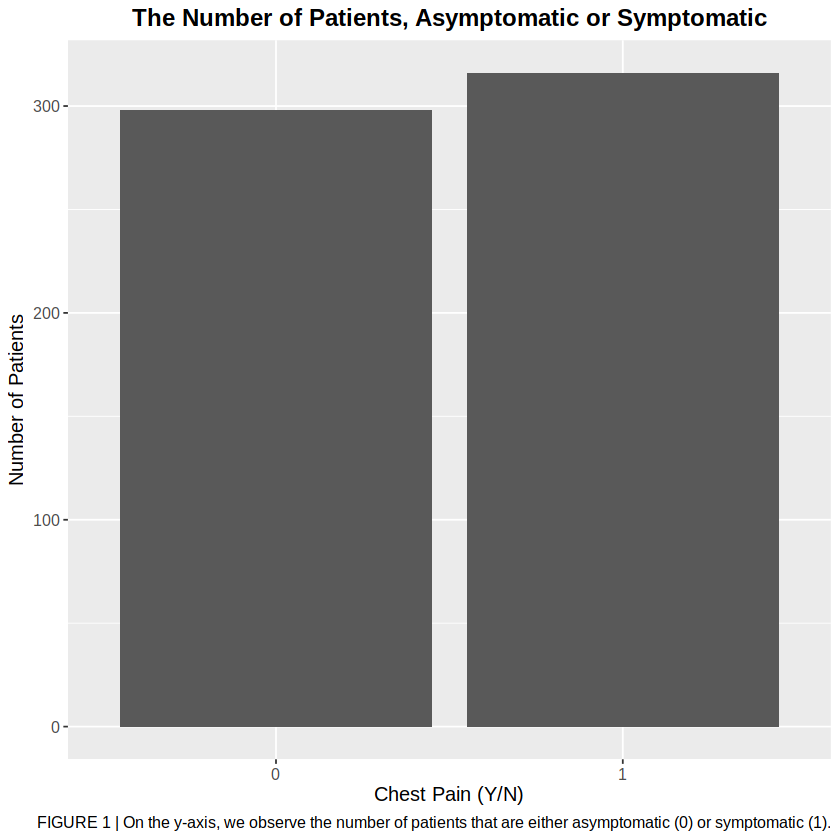

In [32]:
chest_pain_bar <- hd_train |>
                  ggplot(aes(x = chest_pain)) +
                  geom_bar() +
                  labs(x = "Chest Pain (Y/N)", y = "Number of Patients",  fill = "Chest Pain",
                       title = "The Number of Patients, Asymptomatic or Symptomatic",
                       caption = "FIGURE 1 | On the y-axis, we observe the number of patients that are either asymptomatic (0) or symptomatic (1).") +
                  theme(text = element_text(size = 12),
                        plot.title = element_text(hjust = 0.5, face = "bold"),
                        plot.caption = element_text(colour = "black")) 
chest_pain_bar

 - We observe that the classes of the sample are **balanced** upon adding together the chest pain types 1,2,3 into just one class.

#### **e) Before we train the classifier, we should preprocess the data as it is sensitive to the scale of the predictors.**

In [34]:
hd_recipe <- recipe(chest_pain ~ ., data = hd_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())
hd_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

#### **f) We can now train the classifier by randomly using K = 4.**

In [35]:
hd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
           set_engine("kknn") |>
           set_mode("classification")
hd_spec

hd_fit <- workflow() |>
          add_recipe(hd_recipe) |>
          add_model(hd_spec) |>
          fit(data = hd_train)
hd_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 4
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(4,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.237785
Best kernel: rectangular
Best k: 4

#### **g) Adding our predictions column to the data set.**

In [36]:
hd_predictions <- predict(hd_fit, hd_test) |>
                  bind_cols(hd_test)
hd_predictions

.pred_class,age,resting_bp,serum_cholesterol,max_heart_rate,chest_pain
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,53,140,203,155,0
0,62,138,294,106,0
0,58,100,248,122,0
⋮,⋮,⋮,⋮,⋮,⋮
1,58,140,211,165,1
0,56,120,193,162,1
1,45,128,308,170,1


#### **h) Let's assess the performance of the classifier and see if we need to choose a different K value.**

In [37]:
hd_accuracy <- hd_predictions |>
               metrics(truth = chest_pain, estimate = .pred_class) |>
               filter(.metric == "accuracy")
hd_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.756691


In [41]:
matrix <- hd_predictions |>
          conf_mat(truth = chest_pain, estimate = .pred_class)
matrix

          Truth
Prediction   0   1   2   3
         0 139  40   0   0
         1  60 172   0   0
         2   0   0   0   0
         3   0   0   0   0

- The accuracy is **not great** for K = 4 and we can see in the confusion matrix that the predictions are **not always in line with the truth**. Therefore, we need to further evaluate our model to increase its accuracy if we hope to use it in clinical applications.

#### **i) Employing cross-validation, we can determine the best value for K.**

In [42]:
hd_vfold <- vfold_cv(hd_train, v = 5, strata = chest_pain)

hd_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
             set_engine("kknn") |>
             set_mode("classification")

hd_k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

hd_results <- workflow() |>
              add_recipe(hd_recipe) |>
              add_model(hd_spec_2) |>
              tune_grid(resamples = hd_vfold, grid = hd_k_vals) |>
              collect_metrics() 

hd_accuracies <- hd_results |>
                 filter(.metric == "accuracy")
hd_accuracies

! Fold1: internal:
  There were 30 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 29 ...

! Fold2: internal:
  There were 30 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 29 ...

! Fold3: internal:
  There were 30 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9007029,5,0.01026895,Preprocessor1_Model01
2,accuracy,multiclass,0.9007029,5,0.01026895,Preprocessor1_Model02
3,accuracy,multiclass,0.7477458,5,0.01800431,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,multiclass,0.7020297,5,0.02664620,Preprocessor1_Model28
29,accuracy,multiclass,0.6923003,5,0.01989376,Preprocessor1_Model29
30,accuracy,multiclass,0.6923003,5,0.01989376,Preprocessor1_Model30


#### **j) Plot the accuracies to pick a value for K.**

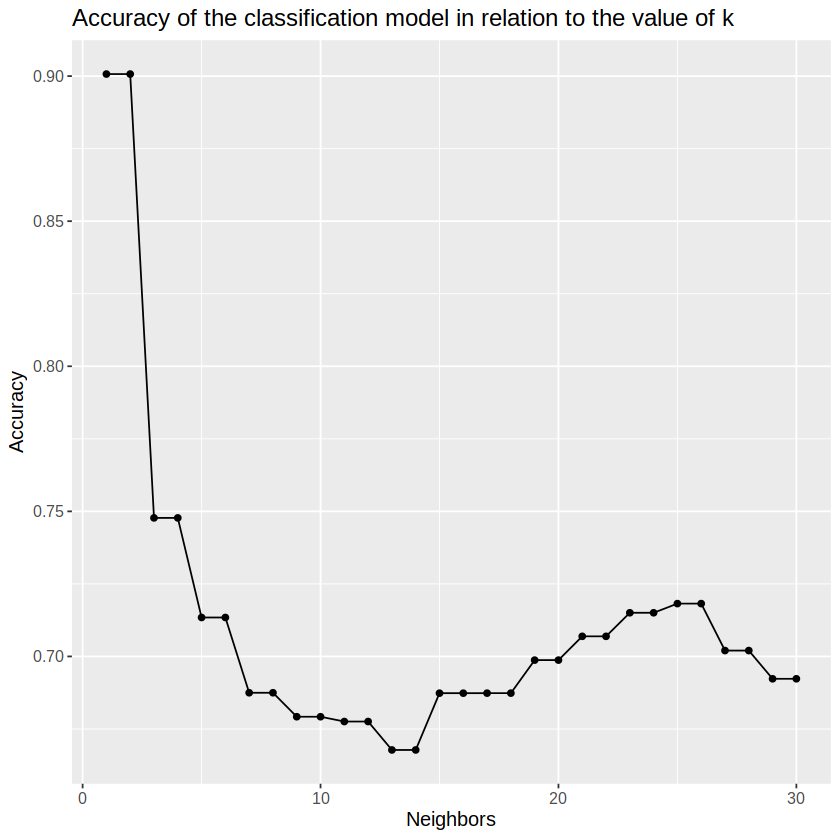

In [58]:
which_k <- hd_accuracies |>
           ggplot(aes(x = neighbors, y = mean)) +
           geom_point() +
           geom_line() +
           labs(x = "Neighbors", y = "Accuracy") + 
           ggtitle("Accuracy of the classification model in relation to the value of k") +
           theme(text = element_text(size = 12))
which_k

- In the graph presented above, a **huge drop in accuracy** can be observed as the chosen value of **k increases past 2**.

In [121]:
hd_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
           set_engine("kknn") |>
           set_mode("classification")

hd_fit_best <- workflow() |>
          add_recipe(hd_recipe) |>
          add_model(hd_spec_best) |>
          fit(data = hd_train)

hd_predictions_best <- predict(hd_fit_best, hd_test) |>
                       bind_cols(hd_test)

hd_accuracy_best <- hd_predictions_best |>
               metrics(truth = chest_pain, estimate = .pred_class) |>
               filter(.metric == "accuracy")

matrix_best <- hd_predictions_best |>
               conf_mat(truth = chest_pain, estimate = .pred_class)

hd_accuracy_best
matrix_best

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.919708


          Truth
Prediction   0   1   2   3
         0 185  19   0   0
         1  14 193   0   0
         2   0   0   0   0
         3   0   0   0   0

In [120]:
hd_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
           set_engine("kknn") |>
           set_mode("classification")

hd_fit_best <- workflow() |>
          add_recipe(hd_recipe) |>
          add_model(hd_spec_best) |>
          fit(data = hd_train)

hd_predictions_best <- predict(hd_fit_best, hd_test) |>
                       bind_cols(hd_test)

hd_accuracy_best <- hd_predictions_best |>
               metrics(truth = chest_pain, estimate = .pred_class) |>
               filter(.metric == "accuracy")

matrix_best <- hd_predictions_best |>
               conf_mat(truth = chest_pain, estimate = .pred_class)

hd_accuracy_best
matrix_best

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.756691


          Truth
Prediction   0   1   2   3
         0 139  40   0   0
         1  60 172   0   0
         2   0   0   0   0
         3   0   0   0   0

#### **k) Let's calculate precision and recall for K = 2 and K = 3**

In [122]:
precision_2 <- 193/(193+14)
precision_2

recall_2 <- 193/(193+19)
recall_2

precision_3 <- 172/(172+60)
precision_3

recall_3 <- 172/(172+40)
recall_3

[1] 0.9323671

[1] 0.9103774

[1] 0.7413793

[1] 0.8113208

- **True positive**: bottom right
- **False positive**: bottom left
- **True negative**: top left
- **False negative**: top right

- **Precision** is a measure of how many symptomatic predictions were correctly predicted.

- **Recall** is a measure of how many symptomatic predictions of the test set were predicted to be symptomatic.

- We want **high recall** more than high accuracy, as if an individual is prone to having a heart attack, we want to make sure that they know that they are, based on their health predictors.

- The data shows much **higher recall, precision, and accuracy** with K = 2 rather than K = 3.
- Let's visualize the data to see why this is the case.

#### **l) Let's visualize our data!**

## 3) Discussion

#### **a) Results**

#### **b) Was this what was expected?**

#### **c) What impact can these findings have?**

#### **d) What are some future questions this analysis may lead to?**

## 4) References

Centers for Disease Control and Prevention. (2021, July 19). Coronary artery disease. Centers for Disease Control and Prevention. https://www.cdc.gov/heartdisease/coronary_ad.htm#:~:text=Print-,Coronary%20Artery%20Disease,This%20process%20is%20called%20atherosclerosis. 

NHS. (n.d.). Heart Attack. NHS choices. 
https://www.nhs.uk/conditions/heart-attack/symptoms/ 